In [1]:
import torch
import torchvision
from torchvision.datasets import ImageFolder
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import shutil
from sklearn.model_selection import train_test_split
from transformers import AutoProcessor, AutoModel
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
from transformers import AutoModel, AutoProcessor, CLIPModel, CLIPProcessor

e:\repos\CLIP_multimodal_search\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Этап 1. Fine-tuning CLIP

### 1. Работа с данными

In [2]:
class FashionDataset(Dataset):
    def __init__(self, csv_file, images_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.images_dir = images_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_name = self.data.iloc[idx]['image']
        description = self.data.iloc[idx]['description']
        
        img_path = os.path.join(self.images_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
            
        return image, description

In [3]:
dataset = FashionDataset(
    csv_file='archive/data.csv',
    images_dir='archive/data',
    transform=transforms.ToTensor()
)

#### Несколько картинок из датасета с описаниями

Round toed, black sports shoes with red accents, low top styling and central lace-ups Leather upper with stitched detail, overlay, Formstrip and Ducati branding on the sides and reinforced heel collar with branding Soft tongue and inner, branding on the tongue Cushioned footbed with branding at the heel Printed detail at the midsole Textured rubber outsole with patterned grooves and branding Warranty: 3 months against manufacturing defects only


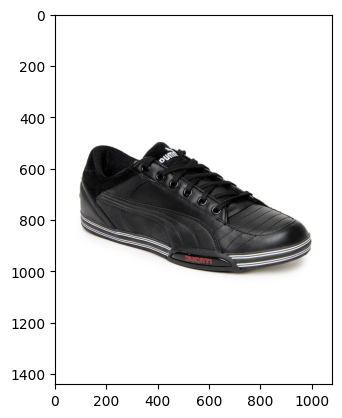

In [4]:
image, label = dataset.__getitem__(0)
plt.imshow(image.permute(1, 2, 0))
print(label)

Style Note Built with the breathability and zero-distraction Fit that athletes demand, these boardshorts come in a body-friendly design. These high-performance shorts are great for a day out at the beach and are designed to aid your aquatic performance. Team them with T-shirts and flip flops. Product Details Charcoal grey boardshorts, with a velcro closure and a cord tie detail, zipped pocket and a nike swoosh on left leg Material and Care 100% polyester Machine wash separately in cold water using a mild detergent Do not bleach Tumble dry low Cool iron; do not iron on decorations Size and fit Regular fit


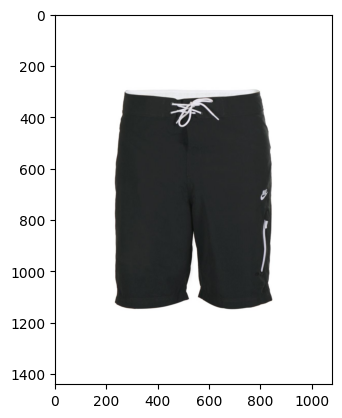

In [5]:
image, label = dataset.__getitem__(1)
plt.imshow(image.permute(1, 2, 0))
print(label)

Teal  handbag that has stitch detailing with a pleated and panel design on the front One main zipped compartment that has an inner zipped pocket  and an organiser sleeve One zipped pocket on the front One long, adjustable strap woven through metallic loops for carrying ease and style One zipped pocket at the back


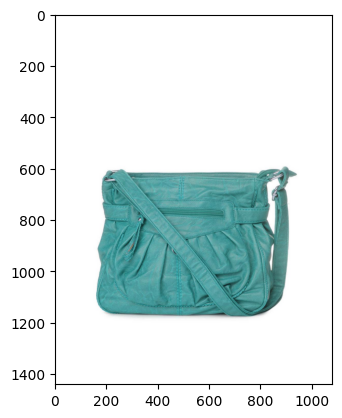

In [6]:
image, label = dataset.__getitem__(2)
plt.imshow(image.permute(1, 2, 0))
print(label)

#### Разрешение картинок

In [7]:
image.size()

torch.Size([3, 1440, 1080])

In [8]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

dataset = FashionDataset(
    csv_file='archive/data.csv',
    images_dir='archive/data',
    transform=transform
)

dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=True,
)

In [9]:
from collections import Counter

def preprocess_data(csv_file, images_dir, output_dir='cleaned_data'):
    # Создаем директорию для очищенных данных
    os.makedirs(output_dir, exist_ok=True)
    os.makedirs(os.path.join(output_dir, 'images'), exist_ok=True)
    
    # Загружаем данные
    df = pd.read_csv(csv_file)
    
    print(f"Исходный размер датасета: {len(df)}")
    
    # Удаляем строки с пустыми значениями в нужных столбцах
    df_cleaned = df.dropna(subset=['image', 'description'])
    print(f"После удаления пустых значений: {len(df_cleaned)}")
    
    # Удаляем дубликаты по названию изображения
    df_cleaned = df_cleaned.drop_duplicates(subset=['image'])
    print(f"После удаления дубликатов по изображению: {len(df_cleaned)}")
    
    # Удаляем дубликаты по описанию (если нужно более строго)
    df_cleaned = df_cleaned.drop_duplicates(subset=['description'])
    print(f"После удаления дубликатов по описанию: {len(df_cleaned)}")
    
    # Проверяем существование файлов изображений
    valid_rows = []
    missing_images = []
    
    for idx, row in df_cleaned.iterrows():
        img_path = os.path.join(images_dir, row['image'])
        if os.path.exists(img_path):
            valid_rows.append(row)
        else:
            missing_images.append(row['image'])
    
    df_final = pd.DataFrame(valid_rows)
    print(f"После проверки существования изображений: {len(df_final)}")
    print(f"Отсутствующие изображения: {len(missing_images)}")
    
    train_df, test_df = train_test_split(
        df_final, 
        test_size=0.05, 
        random_state=42,
        shuffle=True
    )
    
    print(f"Train размер: {len(train_df)}")
    print(f"Test размер: {len(test_df)}")
    
    # def copy_images(df, split_name):
    #     split_dir = os.path.join(output_dir, split_name)
    #     os.makedirs(split_dir, exist_ok=True)
    #     os.makedirs(os.path.join(split_dir, 'images'), exist_ok=True)
        
    #     for _, row in df.iterrows():
    #         src_path = os.path.join(images_dir, row['image'])
    #         dst_path = os.path.join(split_dir, 'images', row['image'])
    #         shutil.copy2(src_path, dst_path)
        
    #     # Сохраняем CSV файл
    #     df.to_csv(os.path.join(split_dir, f'{split_name}.csv'), index=False)
    
    # copy_images(train_df, 'train')
    # copy_images(test_df, 'test')
    
    # # Сохраняем общий очищенный датасет
    # df_final.to_csv(os.path.join(output_dir, 'cleaned_data.csv'), index=False)
    
    return train_df, test_df

# Запускаем предобработку
train_df, test_df = preprocess_data('archive/data.csv', 'archive/data')

Исходный размер датасета: 44441
После удаления пустых значений: 44160
После удаления дубликатов по изображению: 44160
После удаления дубликатов по описанию: 38856
После проверки существования изображений: 38856
Отсутствующие изображения: 0
Train размер: 36913
Test размер: 1943


In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = FashionDataset(
    csv_file='cleaned_data/train/data.csv',
    images_dir='cleaned_data/train/data',
    transform=transform
)

train_dataloader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
)

test_dataset = FashionDataset(
    csv_file='cleaned_data/test/data.csv',
    images_dir='cleaned_data/test/data',
    transform=transform
)

test_dataloader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=True,
)

### 2. Работа с моделью

In [11]:
model_name = "openai/clip-vit-base-patch32"
model = AutoModel.from_pretrained(model_name).to('cuda')
processor = AutoProcessor.from_pretrained(model_name)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [12]:
images, texts = next(iter(test_dataloader))

In [13]:
texts

('Style Note With its classic styling this shirt from myntra is a piece that will easily slot into your daily wear wardrobe. Made of pure cotton this shirt lets you stay comfortable even on sunny days. Pair it with formal trousers and polished derby shoes for a look that exudes complete control and confidence. Product Details Green and white striped shirt, spread collar, long sleeves with buttoned cuffs, patch pocket on the left chest, full buttoned placket, cross grain yoke at back and a curved hem Material and Care 100% cotton Machine wash cold Warm iron Size and Fit Regular fit The model (height 6\' and shoulders 18") is wearing a size M',
 'Pear shaped base with green and blue colour patterns A wide pear shaped dangler with intricate coloured patterns Has bead drops from the base of the dangler Post and back closure',
 'Look great in this 100% polyester, sweat absorbing t-shirt and feel dry all day!   ',
 'Black sleeveless dress with a round neck, gathers at the front, yoke at the 

In [14]:
inputs = processor(text=texts, images=images, return_tensors="pt", padding=True, truncation=True).to(model.device)

with torch.no_grad():
    outputs = model(**inputs)
    clip_logit_score = outputs.logits_per_image

print("CLIP logit score:", clip_logit_score)

It looks like you are trying to rescale already rescaled images. If the input images have pixel values between 0 and 1, set `do_rescale=False` to avoid rescaling them again.


CLIP logit score: tensor([[18.0006, 15.5676, 19.3203, 25.9794, 18.2035, 18.9008, 17.3662, 20.2734],
        [18.2710, 15.3856, 19.6103, 25.7594, 18.3068, 18.9705, 17.5999, 20.2091],
        [18.3701, 15.5417, 19.6108, 25.9764, 18.3796, 19.0527, 17.6190, 20.4279],
        [18.6475, 15.6416, 19.7964, 26.0309, 18.5431, 19.1742, 17.7932, 20.5699],
        [18.2380, 15.4694, 19.4391, 25.9802, 18.5243, 18.9962, 17.4584, 20.3052],
        [18.5340, 15.8169, 19.6274, 25.9783, 18.4505, 19.1142, 17.7463, 20.6477],
        [18.3354, 15.4604, 19.6093, 25.9303, 18.6033, 19.0871, 17.6626, 20.3125],
        [18.5062, 15.5843, 19.6645, 26.0714, 18.5056, 19.0898, 17.6866, 20.4806]],
       device='cuda:0')


In [15]:
img_emb = outputs.image_embeds  
txt_emb = outputs.text_embeds   

img_emb = torch.nn.functional.normalize(img_emb, dim=-1)
txt_emb = torch.nn.functional.normalize(txt_emb, dim=-1)

clip_scores = (img_emb * txt_emb).sum(dim=-1)

In [16]:
clip_scores

tensor([0.1800, 0.1539, 0.1961, 0.2603, 0.1852, 0.1911, 0.1766, 0.2048],
       device='cuda:0')

In [17]:
del model
del processor

### 3. Дообучение

In [18]:
class Config:
    batch_size = 32
    learning_rate = 5e-5
    num_epochs = 4
    warmup_steps = 1000
    log_interval = 50
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "openai/clip-vit-base-patch32"
    save_dir = "checkpoints"
    max_length = 77


class FashionCLIP(nn.Module):
    def __init__(self, model_name="openai/clip-vit-base-patch32"):
        super(FashionCLIP, self).__init__()
        self.model = CLIPModel.from_pretrained(model_name)
        self.processor = CLIPProcessor.from_pretrained(model_name)
        
        # Замораживаем базовые слои
        for param in self.model.parameters():
            param.requires_grad = False
            
        # Размораживаем последние слои для дообучения
        # Vision Transformer - последние слои
        for param in self.model.vision_model.encoder.layers[-2:].parameters():
            param.requires_grad = True
            
        # Text Transformer - последние слои  
        for param in self.model.text_model.encoder.layers[-2:].parameters():
            param.requires_grad = True
            
        # Проекционные слои
        for param in self.model.visual_projection.parameters():
            param.requires_grad = True
        for param in self.model.text_projection.parameters():
            param.requires_grad = True
            
    def forward(self, images, input_ids, attention_mask):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=images,
            return_loss=False
        )
        return outputs.image_embeds, outputs.text_embeds
    
    def encode_image(self, images):
        return self.model.get_image_features(pixel_values=images)
    
    def encode_text(self, input_ids, attention_mask):
        return self.model.get_text_features(
            input_ids=input_ids, 
            attention_mask=attention_mask
        )

def clip_score(logits_per_image, logits_per_text):
    labels = torch.arange(logits_per_image.shape[0]).to(logits_per_image.device)
    
    img_acc = (logits_per_image.argmax(dim=1) == labels).float().mean()
    text_acc = (logits_per_text.argmax(dim=0) == labels).float().mean()
    
    return (img_acc + text_acc) / 2 * 100

def validate(model, val_loader, epoch):
    model.eval()
    total_clip_score = 0
    num_batches = 0
    
    with torch.no_grad():
        for images, texts in tqdm(val_loader, desc=f"Validation Epoch {epoch}"):
            # Подготовка изображений
            images = [image for image in images]  # Convert to list for processor
            processed_images = model.processor(images=images, return_tensors="pt")
            pixel_values = processed_images['pixel_values'].to(Config.device)
            
            # Подготовка текстов
            processed_texts = model.processor(
                text=texts, 
                padding=True, 
                truncation=True,
                max_length=Config.max_length,
                return_tensors="pt"
            )
            input_ids = processed_texts['input_ids'].to(Config.device)
            attention_mask = processed_texts['attention_mask'].to(Config.device)
            
            # Получение эмбеддингов
            image_features, text_features = model(
                pixel_values, input_ids, attention_mask
            )
            
            # Нормализация
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            
            # Вычисление similarity
            logit_scale = model.model.logit_scale.exp()
            logits_per_image = logit_scale * image_features @ text_features.t()
            logits_per_text = logits_per_image.t()
            
            batch_clip_score = clip_score(logits_per_image, logits_per_text)
            total_clip_score += batch_clip_score.item()
            num_batches += 1
    
    avg_clip_score = total_clip_score / num_batches
    return avg_clip_score

# Основной цикл обучения
def train_clip_model():
    # Инициализация модели
    model = FashionCLIP(Config.model_name).to(Config.device)
    
    trainable_params = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.AdamW(
        trainable_params,
        lr=Config.learning_rate,
        weight_decay=0.1,
        betas=(0.9, 0.98),
        eps=1e-6
    )
    
    # Scheduler
    scheduler = optim.lr_scheduler.CosineAnnealingLR(
        optimizer, 
        T_max=len(train_dataloader) * Config.num_epochs
    )
    
    train_losses = []
    train_scores = []
    val_scores = []

    
    for epoch in range(Config.num_epochs):
        model.train()
        running_loss = 0.0
        running_clip_score = 0.0
        num_batches = 0
        
        progress_bar = tqdm(train_dataloader, desc=f'Epoch {epoch+1}/{Config.num_epochs}')
        
        for batch_idx, (images, texts) in enumerate(progress_bar):
            # Подготовка данных
            processed_images = model.processor(images=images, return_tensors="pt")
            pixel_values = processed_images['pixel_values'].to(Config.device)
            
            processed_texts = model.processor(
                text=texts, 
                padding=True, 
                truncation=True,
                max_length=Config.max_length,
                return_tensors="pt"
            )
            input_ids = processed_texts['input_ids'].to(Config.device)
            attention_mask = processed_texts['attention_mask'].to(Config.device)
            
            # Forward
            image_features, text_features = model(pixel_values, input_ids, attention_mask)
            
            # Нормализация
            image_features = image_features / image_features.norm(dim=-1, keepdim=True)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            
            logit_scale = model.model.logit_scale.exp()
            logits_per_image = logit_scale * image_features @ text_features.t()
            logits_per_text = logits_per_image.t()
            
            labels = torch.arange(len(images)).to(Config.device)
            loss_img = nn.CrossEntropyLoss()(logits_per_image, labels)
            loss_txt = nn.CrossEntropyLoss()(logits_per_text, labels)
            loss = (loss_img + loss_txt) / 2
            
            # Backward
            optimizer.zero_grad()
            loss.backward()
            
            optimizer.step()
            scheduler.step()
            
            batch_clip_score = clip_score(logits_per_image, logits_per_text)
            
            running_loss += loss.item()
            running_clip_score += batch_clip_score.item()
            num_batches += 1
            
            # Логирование
            if (batch_idx + 1) % Config.log_interval == 0:
                avg_loss = running_loss / num_batches
                avg_score = running_clip_score / num_batches
                current_lr = scheduler.get_last_lr()[0]
                
                progress_bar.set_postfix({
                    'Loss': f'{avg_loss:.4f}',
                    'CLIP Score': f'{avg_score:.2f}%',
                    'LR': f'{current_lr:.2e}'
                })
        
        # Валидация в конце эпохи
        avg_val_score = validate(model, test_dataloader, epoch + 1)
        
        # Сохранение метрик
        epoch_loss = running_loss / num_batches
        epoch_train_score = running_clip_score / num_batches
        
        train_losses.append(epoch_loss)
        train_scores.append(epoch_train_score)
        val_scores.append(avg_val_score)
        
        print(f'\nEpoch {epoch+1} завершена:')
        print(f'Train Loss: {epoch_loss:.4f}')
        print(f'Train CLIP Score: {epoch_train_score:.2f}%')
        print(f'Val CLIP Score: {avg_val_score:.2f}%')
        print(f'Learning Rate: {scheduler.get_last_lr()[0]:.2e}')
        
        # Сохранение чекпоинта
        checkpoint_path = os.path.join(Config.save_dir, f'clip_transformers_epoch_{epoch+1}.pth')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': epoch_loss,
            'train_score': epoch_train_score,
            'val_score': avg_val_score,
        }, checkpoint_path)
    
    return train_losses, train_scores, val_scores, model




# Запуск обучения
if __name__ == "__main__":
    print("Старт обучения")
    train_losses, train_scores, val_scores, trained_model = train_clip_model()
    
    final_val_score = val_scores[-1]
    print(f"\nФинальный CLIP Score на валидации: {final_val_score:.2f}%")


    
    

Старт обучения


Validation Epoch 1: 100%|██████████| 486/486 [13:24<00:00,  1.66s/it]



Epoch 1 завершена:
Train Loss: 0.7074
Train CLIP Score: 71.21%
Val CLIP Score: 84.41%
Learning Rate: 4.27e-05


Validation Epoch 2: 100%|██████████| 486/486 [13:40<00:00,  1.69s/it]



Epoch 2 завершена:
Train Loss: 0.3254
Train CLIP Score: 87.05%
Val CLIP Score: 88.14%
Learning Rate: 2.50e-05


Validation Epoch 3: 100%|██████████| 486/486 [13:07<00:00,  1.62s/it]



Epoch 3 завершена:
Train Loss: 0.2016
Train CLIP Score: 92.07%
Val CLIP Score: 93.51%
Learning Rate: 7.32e-06


Validation Epoch 4: 100%|██████████| 486/486 [13:39<00:00,  1.69s/it]



Epoch 4 завершена:
Train Loss: 0.1309
Train CLIP Score: 94.98%
Val CLIP Score: 94.11%
Learning Rate: 0.00e+00

Финальный CLIP Score на валидации: 94.11%


In [19]:
def plot_training_curves(train_losses, train_scores, val_scores):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Loss
    ax1.plot(range(1, len(train_losses) + 1), train_losses, 'b-', linewidth=2, label='Train Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training Loss')
    ax1.legend()
    
    # CLIP score
    epochs = range(1, len(train_scores) + 1)
    ax2.plot(epochs, train_scores, 'g-', linewidth=2, label='Train CLIP Score')
    ax2.plot(epochs, val_scores, 'r-', linewidth=2, label='Val CLIP Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('CLIP Score (%)')
    ax2.set_title('CLIP Score Progress')
    ax2.legend()
    
    plt.tight_layout()
    plt.savefig('training_curves_transformers.png', dpi=300, bbox_inches='tight')
    plt.show()

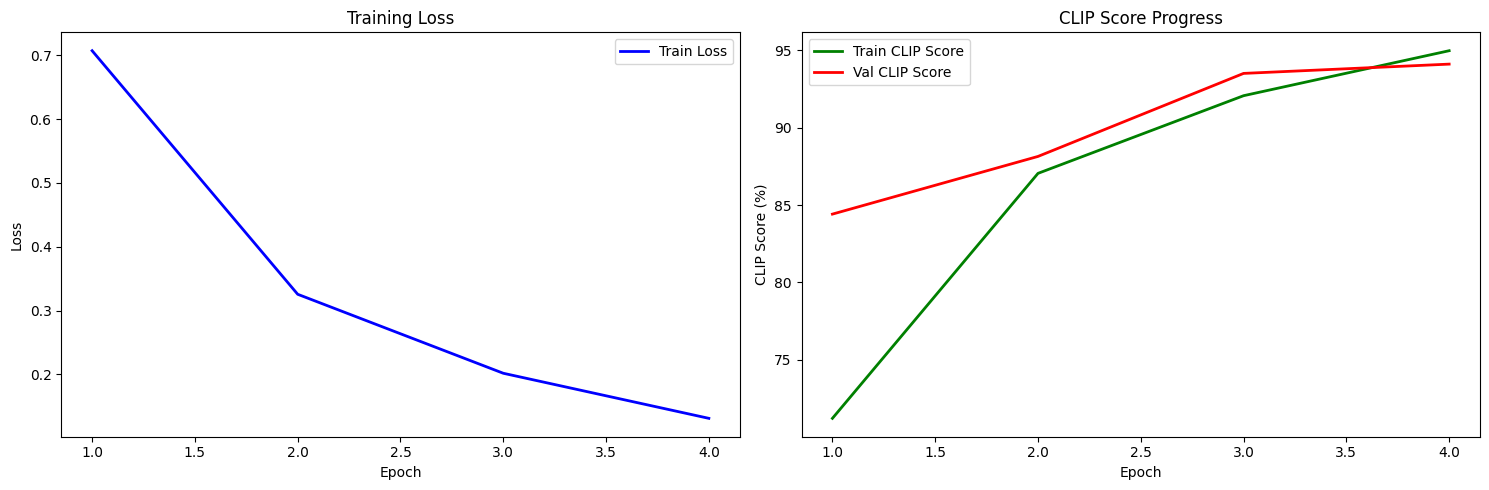

In [20]:
plot_training_curves(train_losses, train_scores, val_scores)

In [21]:

# Поисковый движок через transformers
class FashionSearchEngine:
    def __init__(self, model_path, csv_file, image_dir):
        # Загрузка модели и процессора
        self.model = CLIPModel.from_pretrained(model_path)
        self.processor = CLIPProcessor.from_pretrained(model_path)
        self.model.to(Config.device)
        self.model.eval()
        
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        
        # Precompute image features
        print("Precomputing image features...")
        self.image_features = self._precompute_features()
        
    def _precompute_features(self):
        features = []
        for _, row in tqdm(self.data.iterrows(), total=len(self.data)):
            image_path = os.path.join(self.image_dir, row['image'])
            image = Image.open(image_path).convert('RGB')
            
            processed_image = self.processor(images=image, return_tensors="pt")
            pixel_values = processed_image['pixel_values'].to(Config.device)
            
            with torch.no_grad():
                image_feature = self.model.get_image_features(pixel_values=pixel_values)
                image_feature = image_feature / image_feature.norm(dim=-1, keepdim=True)
                features.append(image_feature.cpu())
                
        return torch.cat(features, dim=0)
    
    def search(self, text_query, top_k=5):
        with torch.no_grad():
            # Кодируем текст
            processed_text = self.processor(
                text=text_query, 
                return_tensors="pt", 
                padding=True, 
                truncation=True
            )
            input_ids = processed_text['input_ids'].to(Config.device)
            attention_mask = processed_text['attention_mask'].to(Config.device)
            
            text_features = self.model.get_text_features(
                input_ids=input_ids, 
                attention_mask=attention_mask
            )
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            
            # Вычисляем similarity
            logit_scale = self.model.logit_scale.exp()
            similarity = (self.image_features.to(Config.device) @ text_features.T).squeeze()
            top_scores, top_indices = similarity.topk(top_k)
            
        results = []
        for score, idx in zip(top_scores, top_indices):
            row = self.data.iloc[idx]
            results.append({
                'image': row['image'],
                'description': row['description'],
                'score': score.item()
            })
            
        return results

In [22]:
print("\nИнициализация поискового движка...")
search_engine = FashionSearchEngine(
    model_path='checkpoints/clip_fashion_epoch_4',
    csv_file='data.csv',
    image_dir='images'
)

# Тестовый поиск
test_queries = [
    "красное платье",
    "синие джинсы", 
    "черные туфли на каблуке",
    "белая футболка",
    "стильная куртка"
]

print("\nТестовый поиск:")
for query in test_queries:
    print(f"\nПоиск: '{query}'")
    results = search_engine.search(query, top_k=3)
    for i, result in enumerate(results, 1):
        print(f"  {i}. {result['description']} (score: {result['score']:.3f})")


Инициализация поискового движка...


OSError: checkpoints/clip_fashion_epoch_4 is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`